In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import pandas as pd
import os 

import pickle

E:\Anaconda3\envs\ML_new\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
E:\Anaconda3\envs\ML_new\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
E:\Anaconda3\envs\ML_new\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
E:\Anaconda3\envs\ML_new\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# method used for saving object as pickle
def save_object_as_pickle(obj, filename):
    with open(filename, 'wb') as file:
        pickle.dump(obj, file, pickle.HIGHEST_PROTOCOL)

In [3]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [4]:
[test_set_raw, valid_set_raw, train_set_raw], info = tfds.load(
    "tf_flowers",
split=["train[:10%]", "train[10%:25%]", "train[25%:]"], as_supervised=True,
with_info=True)

In [5]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='~\\tensorflow_datasets\\tf_flowers\\3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [6]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples

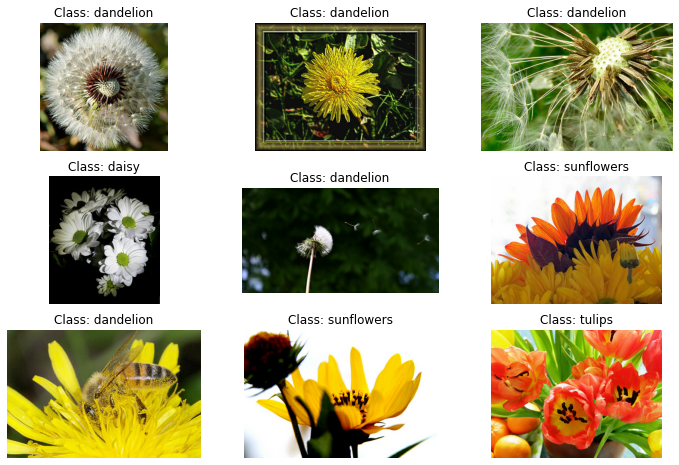

In [7]:
plt.figure(figsize=(12, 8))
index = 0
sample_images = train_set_raw.take(9) 
for image, label in sample_images:
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label])) 
    plt.axis("off")

# plt.show(block=False)

### Simple CNN building

#### Data preparation

In [8]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224]) 
    return resized_image, label

In [9]:
batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1) 
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

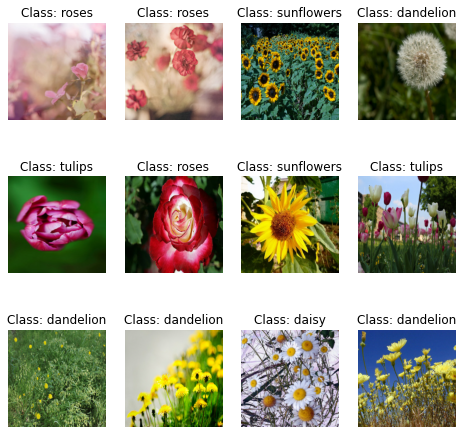

In [10]:
plt.figure(figsize=(8, 8)) 
sample_batch = train_set.take(1)
for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index + 1) 
        plt.imshow(X_batch[index]/255.0)
        plt.title("Class: {}".format(class_names[y_batch[index]])) 
        plt.axis("off")

# plt.show()

#### Network building

In [11]:
model = keras.models.Sequential([
    keras.layers.Rescaling(scale=1./127.5, offset=-1),
    keras.layers.MaxPooling2D((7,7)),
     keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
     keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
     keras.layers.MaxPooling2D((3,3)),
     keras.layers.Flatten(),
     keras.layers.Dense(128, activation="relu"),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(64, activation="relu"),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(10, activation="softmax")
])

In [12]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [13]:
# model.fit(train_set, validation_data=valid_set, epochs=10)

### Save evaluation results

In [14]:
acc_train = model.evaluate(train_set)[1]
acc_train

E:\Anaconda3\envs\ML_new\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


86/86 [==============================] - 4s 13ms/step - loss: 2.2819 - accuracy: 0.1519


0.15188953280448914

In [15]:
acc_valid = model.evaluate(valid_set)[1]
acc_valid

18/18 [==============================] - 0s 18ms/step - loss: 2.2880 - accuracy: 0.1488


0.14882032573223114

In [16]:
acc_test = model.evaluate(test_set)[1]
acc_test

12/12 [==============================] - 0s 19ms/step - loss: 2.2756 - accuracy: 0.1798


0.17983651161193848

In [17]:
simple_cnn_acc = (acc_train, acc_valid, acc_test)
save_object_as_pickle(simple_cnn_acc,  "simple_cnn_acc.pkl")
simple_cnn_acc

(0.15188953280448914, 0.14882032573223114, 0.17983651161193848)

### Transfer learning

In [18]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

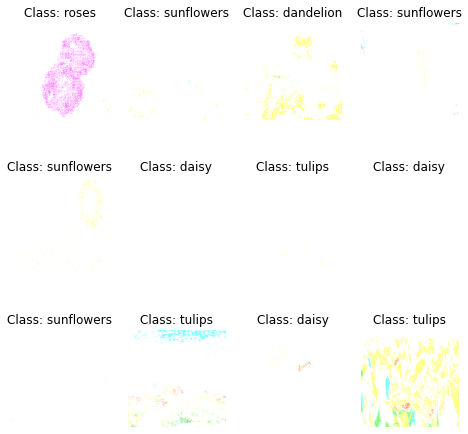

In [19]:
plt.figure(figsize=(8, 8)) 
sample_batch = train_set.take(1)
for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]])) 
        plt.axis("off")

# plt.show()

#### Network building

In [20]:
base_model = tf.keras.applications.xception.Xception(
    weights="imagenet", 
    include_top=False)

In [21]:
# show network structure
# for index, layer in enumerate(base_model.layers): 
#     print(index, layer.name)

In [22]:
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)

model = keras.models.Model(inputs=base_model.input, outputs=output)

In [23]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)

model.compile(loss="sparse_categorical_crossentropy",
    optimizer=optimizer, metrics=["accuracy"])

In [25]:
for layer in base_model.layers:
    layer.trainable = False
    
history1 = model.fit(train_set, validation_data=valid_set, batch_size  = 1,  epochs=5)


Epoch 1/5


ResourceExhaustedError: Graph execution error:

Detected at node 'model/block3_sepconv2/separable_conv2d' defined at (most recent call last):
    File "E:\Anaconda3\envs\ML_new\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "E:\Anaconda3\envs\ML_new\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\kuba2\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\kuba2\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 845, in launch_instance
      app.start()
    File "C:\Users\kuba2\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 612, in start
      self.io_loop.start()
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "E:\Anaconda3\envs\ML_new\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "E:\Anaconda3\envs\ML_new\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "E:\Anaconda3\envs\ML_new\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
      ret = callback()
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\tornado\gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\tornado\gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "C:\Users\kuba2\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 381, in dispatch_queue
      yield self.process_one()
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\tornado\gen.py", line 250, in wrapper
      runner = Runner(ctx_run, result, future, yielded)
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\tornado\gen.py", line 741, in __init__
      self.ctx_run(self.run)
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\tornado\gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "C:\Users\kuba2\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\kuba2\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\kuba2\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\kuba2\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\kuba2\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\kuba2\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2876, in run_cell
      result = self._run_cell(
    File "C:\Users\kuba2\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2922, in _run_cell
      return runner(coro)
    File "C:\Users\kuba2\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\kuba2\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3145, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\kuba2\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\kuba2\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3417, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-24-51c4967e49e5>", line 4, in <module>
      history1 = model.fit(train_set, validation_data=valid_set, epochs=5)
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "E:\Anaconda3\envs\ML_new\lib\site-packages\keras\layers\convolutional\separable_conv2d.py", line 180, in call
      outputs = tf.compat.v1.nn.separable_conv2d(
Node: 'model/block3_sepconv2/separable_conv2d'
OOM when allocating tensor with shape[32,256,55,55] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/block3_sepconv2/separable_conv2d}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_10699]

In [ ]:
for layer in base_model.layers:
    layer.trainable = True
    
history2 = model.fit(train_set, validation_data=valid_set, epochs=10)

### Save evaluation results

In [ ]:
x_acc_train = model.evaluate(train_set)[1]
x_acc_train

In [ ]:
x_acc_valid = model.evaluate(valid_set)[1]
x_acc_valid

In [ ]:
x_acc_test = model.evaluate(test_set)[1]
x_acc_test

In [ ]:
xception_acc = (x_acc_train, x_acc_valid, x_acc_test)
save_object_as_pickle(xception_acc,  "xception_acc.pkl")
xception_acc

### Check saved pickles' data

In [ ]:
print("simple_cnn_acc.pkl\n", pd.read_pickle("simple_cnn_acc.pkl"), "\n")
print("xception_acc.pkl\n", pd.read_pickle("xception_acc.pkl"), "\n")